In [1]:
import numpy as np 
from matplotlib import pyplot as plt
import cv2 

## Smoother implementation

In [2]:
# In this notebook, we implemement the Gaussian Mixture Kalman Filter (GMKF) from Wills et. al. 2017

from scipy.stats import norm
from sklearn.mixture import GaussianMixture

class GMKF():
    def __init__(self, x_init, std_x, y_init, std_y, v_init, std_v, dynamics_params, x_mean, y_mean, v_mean, std_zx, std_zy, N_max = 5) -> None:
        # mean trajectories
        self.x_mean = x_mean
        self.y_mean = y_mean
        self.v_mean = v_mean

        # time variable
        self.t = 0

        # these are also p(x_1 | y_1) or 1|1, or t|t
        self.N = 1 # initial number of mixture components for lateral component

        # Lateral component
        self.wx = np.array([1])
        self.mu_x = np.array([x_init])
        self.std_x = np.array([std_x])
        self.P_x = np.array([std_x**2])

        # Longitudinal component
        self.wy = np.array([1])
        self.mu_y = np.array([y_init, v_init]).T
        self.std_y = np.array([std_y])
        self.std_v = np.array([std_v])
        self.P_y = np.array([[std_y**2, 0], [0, std_v**2]])

        # Dynamics model
        # dynamics params is a tuple of alpha_left, mu_left, std_left, alpha_center, mu_center, std_center, alpha_right, mu_right, std_right, std_v
        self.dynamics_params = dynamics_params 
        self.Nx = 3 # number of mixture components of the dynamics model for the lateral component
        self.N_max = N_max # maximum number of mixture components for the lateral component
        self.preliminary_pruning_weight_thres = 1e-3 # preliminary pruning weight threshold
        self.em_particles = 5_000 # number of particles for EM resampling of the mixture
        self.A = np.array([[1, 1], [0, 1]])
        self.B = np.array([[0], [1]])
        self.C = np.array([[1, 0]])

        # Measurement model
        self.std_zx = np.array([std_zx])
        self.std_zy = np.array([std_zy])
        self.P_zx = np.array([std_zx**2])
        self.P_zy = np.array([std_zy**2])

        # Whole trajectory for smoothing
        self.mu_x_post = []
        self.P_x_post = []
        self.w_x_post = []
        self.mu_y_post = []
        self.P_y_post = []
        self.w_y_post = []

    def predict(self): # p(x_{t+1} | y_{1:t})
        print('Predicting t = {} -> {}'.format(self.t, self.t + 1))
        # predict the state of the system at the next time step
        # the prediction is a mixture of Gaussians

        # ================== #
        # For lateral/lane change dynamics/x #
        # ================== #
        # first, we compute the number of mixture components in the prediction t+1|1:t
        N_tPlus1_t = self.N * self.Nx # N is the number of components for t|t, Nx is the number of components for t+1|t or the dynamics model
        # then, we compute the means of each mixture component
        
        mu_x_pred = np.zeros(N_tPlus1_t)
        P_x_pred = np.zeros(N_tPlus1_t)
        w_x_pred = np.zeros(N_tPlus1_t)

        for s in range(self.N): # s is the index of t|t mixture
            for j in range(self.Nx): # j is the index of t+1|t mixture, or the dynamics model. j=0: left, j=1: center, j=2: right
                l = self.Nx * s + j # lth mixture component of t+1|1:t
                
                mu_x_pred[l] = (self.x_mean[self.t+1] - self.x_mean[self.t]) + self.mu_x[s] + self.dynamics_params[1 + 3*j] # 1, 4, 7 are the means of the dynamics model
                # in dynamics_params, the variances are at index 2, 5, 8
                P_x_pred[l] = self.P_x[s] + self.dynamics_params[2 + 3*j]**2 # the variance is the sum of the variances of the dynamics and the measurement, 2, 5, 8 are the variances of the dynamics model
                w_x_pred[l] = self.wx[s] * self.dynamics_params[0 + 3*j] # the weight is the product of the weights of the dynamics and the measurement

        # ================== #
        # For longitudinal dynamics/y #
        # ================== #
        # For longitudinal component, there is just one mixture component, so it's similar to a regular Kalman Filter
        # Position
        y_tPlus1_t = self.A @ self.mu_y + np.array([0, self.v_mean[self.t+1] - self.v_mean[self.t]]) # mean propagation of the state # 2x1
        P_tPlus1_t = self.A @ self.P_y @ self.A.T + self.B * self.dynamics_params[9]**2 # 9th index is the variance of the velocity
        w_tPlus1_t = self.wy[0]

        # at the end of the prediction step, we have 3x the number of mixture components for the state
        return mu_x_pred, P_x_pred, w_x_pred, y_tPlus1_t, P_tPlus1_t, w_tPlus1_t
    
    def update(self, zx, zy, prediction): # zx: the measured lateral (x) and longitudinal (y) position of the vehicle
        print('Updating t = {}'.format(self.t + 1))
        # the update follows Will's 2017 paper. 
        # prediction argument should come from self.predict()
        mu_x_pred, P_x_pred, w_x_pred, mu_y_pred, P_y_pred, w_y_pred = prediction

        # ================== #
        # For lateral/lane change dynamics/x #
        # ================== #
        # the number of posterior mixture components 
        N_tPlus1_t = mu_x_pred.shape[0]
        N_tPlus1_tPlus1 = N_tPlus1_t # because the measurement mixture has only one component
        mu_x_tPlus1_tPlus1 = np.zeros(N_tPlus1_tPlus1)
        P_x_tPlus1_tPlus1 = np.zeros(N_tPlus1_tPlus1)
        w_x_tPlus1_tPlus1 = np.zeros(N_tPlus1_tPlus1)

        for l in range(N_tPlus1_t):
            # compute the predicted measurement covariance
            sigma_tl = P_x_pred[l] + self.P_zx[0] 
            # compute the Kalman gain
            K_tl = P_x_pred[l] / sigma_tl
            # compute the posterior mean
            ex = zx - mu_x_pred[l]
            mu_x_tPlus1_tPlus1[l] = mu_x_pred[l] + K_tl * ex
            # compute the posterior covariance
            P_x_tPlus1_tPlus1[l] = P_x_pred[l] - K_tl * P_x_pred[l]
            # compute the posterior weight
            w_x_tPlus1_tPlus1[l] = w_x_pred[l] * norm.pdf(ex, 0, np.sqrt(sigma_tl))
            
        # Renormalize the weights
        w_x_tPlus1_tPlus1 = w_x_tPlus1_tPlus1 / np.sum(w_x_tPlus1_tPlus1)

        # ================== #
        # PRUNING OF MIXTURE COMPONENTS #
        # ================== #
        # The pruning of mixture components comprises of two steps:
        # 1. pruning of the mixture components with low weights
        # 2. pruning of the mixture components via resampling with EM

        # 1. pruning of the mixture components with low weights
        components_to_keep = np.where(w_x_tPlus1_tPlus1 > self.preliminary_pruning_weight_thres)[0]
        mu_x_tPlus1_tPlus1 = mu_x_tPlus1_tPlus1[components_to_keep]
        P_x_tPlus1_tPlus1 = P_x_tPlus1_tPlus1[components_to_keep]
        w_x_tPlus1_tPlus1 = w_x_tPlus1_tPlus1[components_to_keep]
        
        # Renormalize the weights
        w_x_tPlus1_tPlus1 = w_x_tPlus1_tPlus1 / np.sum(w_x_tPlus1_tPlus1)
        
        print('N. mix. components prned at LV1: ', N_tPlus1_tPlus1 - mu_x_tPlus1_tPlus1.shape[0])

        # 2. pruning of the mixture components via resampling with EM
        # if the result of the first pruning step is not satisfactory, we perform the second pruning step
        original_number_of_modes = mu_x_tPlus1_tPlus1.shape[0]
        if original_number_of_modes > self.N_max:
            # sample from the Gaussian mixture 10000 times
            particle_modes = np.random.choice(original_number_of_modes, 10000, p=w_x_tPlus1_tPlus1)
            particles = np.random.normal(mu_x_tPlus1_tPlus1[particle_modes], np.sqrt(P_x_tPlus1_tPlus1[particle_modes]))
            # fitting a Gaussian mixture to the samples
            gmm = GaussianMixture(n_components=self.N_max, covariance_type='diag', max_iter=1000, random_state=0).fit(particles.reshape(-1, 1))
            # extracting the parameters of the Gaussian mixture
            mu_x_tPlus1_tPlus1 = gmm.means_.flatten()
            P_x_tPlus1_tPlus1 = gmm.covariances_.flatten()
            w_x_tPlus1_tPlus1 = gmm.weights_.flatten()
            
            print('N. mix. components prned at LV2: ', original_number_of_modes - mu_x_tPlus1_tPlus1.shape[0])

        # ================== #
        # For longitudinal dynamics/y #
        # ================== #
        # Like said, the longitudinal component is similar to a regular Kalman Filter
        # so there is only one mixture component
        # compute the predicted measurement covariance
        sigma_yt = self.C @ P_y_pred @ self.C.T + self.P_zy[0] # scalar
        # compute the Kalman gain
        K_yt = P_y_pred @ self.C.T / sigma_yt # 2x1
        # compute the posterior mean
        ey = zy - self.C @ mu_y_pred
        mu_y_tPlus1_tPlus1 = mu_y_pred + (K_yt * ey).flatten() # 1x2
        # compute the posterior covariance
        P_y_tPlus1_tPlus1 = P_y_pred - K_yt @ self.C @ P_y_pred # 2x2
        # P_y_tPlus1_tPlus1 = P_y_pred - K_yt * sigma_yt * K_yt.T # 2x2 # original equation in the paper, but it's wrong?
        # compute the posterior weight
        w_y_tPlus1_tPlus1 = np.array([w_y_pred])

        return mu_x_tPlus1_tPlus1, P_x_tPlus1_tPlus1, w_x_tPlus1_tPlus1, sigma_tl, mu_y_tPlus1_tPlus1, P_y_tPlus1_tPlus1, w_y_tPlus1_tPlus1, sigma_yt

    def state_write(self, updaton):
        # updaton is the output of self.update()
        mu_x_tPlus1_tPlus1, P_x_tPlus1_tPlus1, w_x_tPlus1_tPlus1, sigma_tl, mu_y_tPlus1_tPlus1, P_y_tPlus1_tPlus1, w_y_tPlus1_tPlus1, sigma_yt = updaton
        
        self.wx = w_x_tPlus1_tPlus1.flatten()
        self.mu_x = mu_x_tPlus1_tPlus1.flatten()
        self.P_x = P_x_tPlus1_tPlus1
        self.N = self.mu_x.shape[0]

        self.wy = w_y_tPlus1_tPlus1.flatten()
        self.mu_y = mu_y_tPlus1_tPlus1.flatten()
        self.P_y = P_y_tPlus1_tPlus1
        
        # save the posterior state values to the history
        self.mu_x_post.append(self.mu_x)
        self.P_x_post.append(self.P_x)
        self.wx_post.append(self.wx)
        
        self.mu_y_post.append(self.mu_y)
        self.P_y_post.append(self.P_y)
        self.wy_post.append(self.wy)

        # move the time step forward
        self.t += 1

In [ ]:
# define the SMOOTHIE class as a child class of GMKF
class SMOOTHIE(GMKF):
    def __init__(self, x_init, std_x, y_init, std_y, v_init, std_v, dynamics_params, x_mean, y_mean, v_mean, std_zx, std_zy, N_max=5) -> None:
        super().__init__(x_init, std_x, y_init, std_y, v_init, std_v, dynamics_params, x_mean, y_mean, v_mean, std_zx, std_zy, N_max)
        # Informative prior for lateral component: unbounded uniform prior
        self.L_xs = np.array([0]) # information. Since x is scalar, L_xs is also scalar. The s stands for smoothed
        self.s_xs = np.array([0]) # information vector
        self.t_xs = np.array([0]) # log-weight
        
        self.t_s = self.t # the variable which keeps track of the time index for the smoothing step
        # according to Balenzuela's paper, t_s will be the first index of the notation, i.e., t_s | t_s + 1
        
        # TODO: Implement longitudinal smoothing
        
    def smooth_measurement(self):
        # ================== #
        # For lateral dynamics/x #
        # ================== #
        # Measurement update
        # The information matrix
        N_b_kPlus1 = self.L_xs.shape[0] # number of mixture components of 
        for l in 
        
        

First, let's pick a sample trajectory, prior to smoothing.

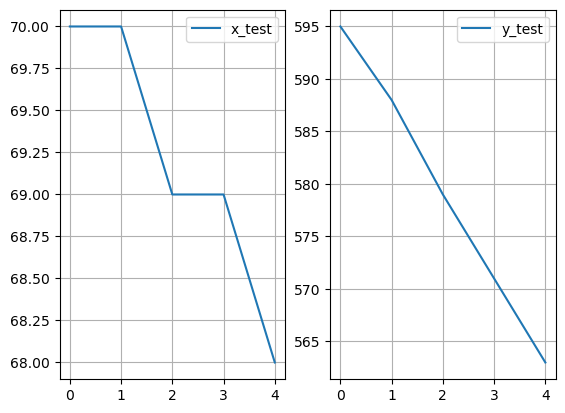

In [3]:

x_mean = np.load('x_mean.npy')
y_mean = np.load('y_mean.npy')
x_samp = np.load('x_sample_from_video.npy')
y_samp = np.load('y_sample_from_video.npy')
v_mean = np.diff(x_mean)

x_test = x_samp[0,:]
y_test = y_samp[0,:]

plt.subplot(1,2,1)
plt.plot(x_test[:5])
# plt.plot(x_mean)
plt.legend(['x_test', 'x_mean'])
plt.grid()
plt.subplot(1,2,2)
plt.plot(y_test[:5])
# plt.plot(y_mean)
plt.grid()
plt.legend(['y_test', 'y_mean'])

Some helper functions to plot the state beliefs.

In [4]:
# plot the GMM of the prediction
from scipy.stats import norm

# Visualization functions
def gmm_pdf(mu, P, w, x):
    pdf = 0
    for l in range(mu.shape[0]):
        pdf += w[l] * norm.pdf(x, mu[l], P[l])
    return pdf

def plot_gmm(mu, P, w):
    x = np.linspace(np.min(mu) - np.max(np.sqrt(P)) * 10, np.max(mu) + np.max(np.sqrt(P)) * 10, 200)
    plt.plot(x, gmm_pdf(mu, P, w, x))
    # add texts denoting the means of the mixture components
    for l in range(mu.shape[0]):
        plt.text(mu[l], 0, str(np.round(mu[l], 2)) + '$\pm$' + str(np.round(np.sqrt(P[l]), 2)), rotation=90, fontsize=8)

def get_params(alpha_left, mu_left, std_left, alpha_center, mu_center, std_center, alpha_right, mu_right, std_right, std_v):
    return (alpha_left, mu_left, std_left, alpha_center, mu_center, std_center, alpha_right, mu_right, std_right, std_v)

Filter setup

In [5]:
# Initialize the filter
# alpha_left, mu_left, std_left, alpha_center, mu_center, std_center, alpha_right, mu_right, std_right, std_y
filt = GMKF(x_init=x_test[0], std_x=0.3, y_init=y_test[0], std_y=0.3, v_init=y_test[1] - y_test[0], std_v=0.2,
            dynamics_params=get_params(alpha_left=0.05, mu_left=-1.5, std_left=0.1, 
                             alpha_center=0.9, mu_center=0, std_center=0.1, 
                             alpha_right=0.05, mu_right=1.5, std_right=0.1,
                             std_v=0.3), 
            x_mean=x_mean, y_mean=y_mean, v_mean=v_mean, std_zx=3.0, std_zy=3.0)

## Filter Iteration

In [6]:
# Variables to log the results
output_length = x_test.shape[0] - 2 # -1 because the v_mean has dimension of x_test.shape[0] - 1
mmse_x = np.zeros(output_length)
mmse_y = np.zeros(output_length)
mmse_v = np.zeros(output_length)
# mmse_x_std = np.zeros(output_length)
mmse_y_std = np.zeros(output_length)
mmse_v_std = np.zeros(output_length)

In [7]:
for i in range(output_length): 
    # predict the state at the next time step
    mu_x_pred, P_x_pred, w_x_pred, y_tPlus1_t, P_tPlus1_t, w_tPlus1_t = filt.predict()
    prediton = (mu_x_pred, P_x_pred, w_x_pred, y_tPlus1_t, P_tPlus1_t, w_tPlus1_t)
    # update the state at the next time step
    mu_x_tPlus1_tPlus1, P_x_tPlus1_tPlus1, w_x_tPlus1_tPlus1, sigma_tl, mu_y_tPlus1_tPlus1, P_y_tPlus1_tPlus1, w_y_tPlus1_tPlus1, sigma_yt = filt.update(zx=x_test[filt.t + 1], zy=y_test[filt.t + 1], prediction=prediton)
    updaton = (mu_x_tPlus1_tPlus1, P_x_tPlus1_tPlus1, w_x_tPlus1_tPlus1, sigma_tl, mu_y_tPlus1_tPlus1, P_y_tPlus1_tPlus1, w_y_tPlus1_tPlus1, sigma_yt)
    
    # log the results
    mmse_x[i] = np.sum(w_x_tPlus1_tPlus1 * mu_x_tPlus1_tPlus1)
    mmse_y[i] = mu_y_tPlus1_tPlus1[0]
    mmse_v[i] = mu_y_tPlus1_tPlus1[1]
    mmse_y_std[i] = np.sqrt(P_y_tPlus1_tPlus1[0,0])
    mmse_v_std[i] = np.sqrt(P_y_tPlus1_tPlus1[1,1])
    
    # save state
    filt.state_write(updaton)

Predicting t = 0 -> 1
Updating t = 1
N. mix. components prned at LV1:  0
Predicting t = 1 -> 2
Updating t = 2
N. mix. components prned at LV1:  0
N. mix. components prned at LV2:  4
Predicting t = 2 -> 3
Updating t = 3
N. mix. components prned at LV1:  0
N. mix. components prned at LV2:  10
Predicting t = 3 -> 4
Updating t = 4
N. mix. components prned at LV1:  0
N. mix. components prned at LV2:  10
Predicting t = 4 -> 5
Updating t = 5
N. mix. components prned at LV1:  0
N. mix. components prned at LV2:  10
Predicting t = 5 -> 6
Updating t = 6
N. mix. components prned at LV1:  0
N. mix. components prned at LV2:  10
Predicting t = 6 -> 7
Updating t = 7
N. mix. components prned at LV1:  0
N. mix. components prned at LV2:  10
Predicting t = 7 -> 8
Updating t = 8
N. mix. components prned at LV1:  0
N. mix. components prned at LV2:  10
Predicting t = 8 -> 9
Updating t = 9
N. mix. components prned at LV1:  0
N. mix. components prned at LV2:  10
Predicting t = 9 -> 10
Updating t = 10
N. mix. c

# Plotting the MMSEs

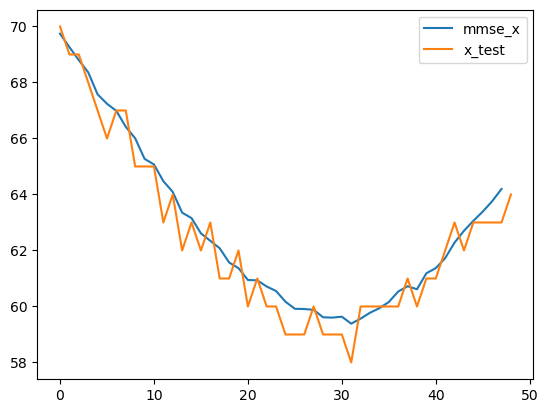

In [8]:
# lateral position X
plt.plot(mmse_x)
plt.plot(x_test[1:])
plt.legend(['mmse_x', 'x_test'])


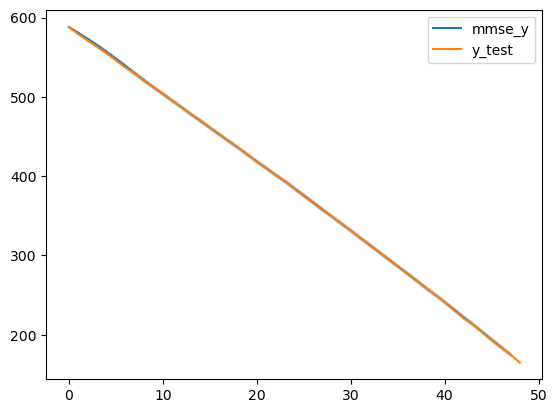

In [9]:
# longitudinal position Y
plt.plot(mmse_y)
plt.plot(y_test[1:])
# draw confidence interval 
plt.fill_between(np.arange(mmse_y.shape[0]), mmse_y - 2 * mmse_y_std, mmse_y + 2 * mmse_y_std, alpha=0.2)
plt.legend(['mmse_y', 'y_test'])


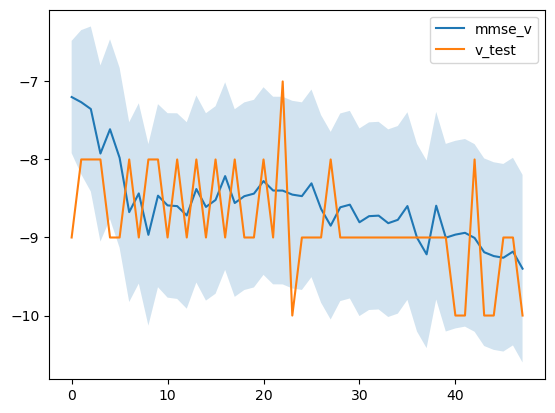

In [10]:
# velocity v 
plt.plot(mmse_v)
plt.plot(y_test[2:] - y_test[1:-1])
# draw confidence interval
plt.fill_between(np.arange(mmse_v.shape[0]), mmse_v - 2 * mmse_v_std, mmse_v + 2 * mmse_v_std, alpha=0.2)
plt.legend(['mmse_v', 'v_test'])

## Visualization of state beliefs

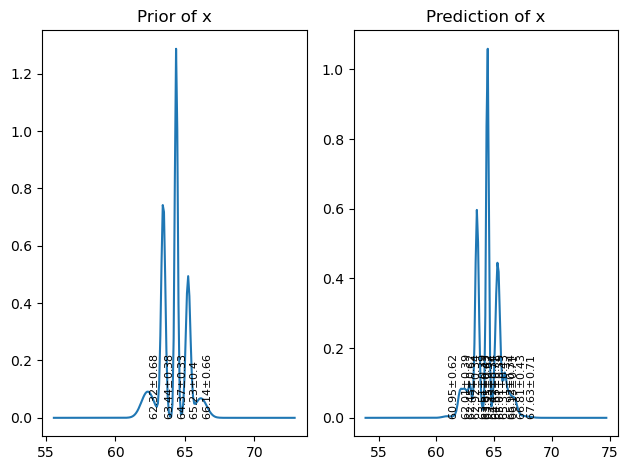

In [11]:
# Prediction of lateral (x) component
plt.figure()
plt.subplot(1,2,1)
# Prior
plot_gmm(np.array(filt.mu_x), np.array(filt.P_x), np.array(filt.wx))
plt.title('Prior of x')

plt.subplot(1,2,2)
# Prediction
plot_gmm(mu_x_pred, P_x_pred, w_x_pred)
plt.title('Prediction of x')

plt.tight_layout()


**Sanity check:** verify that the variances always increase after the prediction step 

In [12]:
# ================== #
# DEBUGGING
# ================== #

print('Prior of y: ', np.array([filt.mu_y[0]]), np.array([filt.P_y[0,0]]), np.array(filt.wy))
print('Prediction of y: ', y_tPlus1_t, P_tPlus1_t, w_tPlus1_t)

Prior of y:  [175.1347213] [3.23210485] [1]
Prediction of y:  [175.21021389  -9.38055922] [[5.04325111 1.00588608]
 [1.25649677 0.45123659]] 1


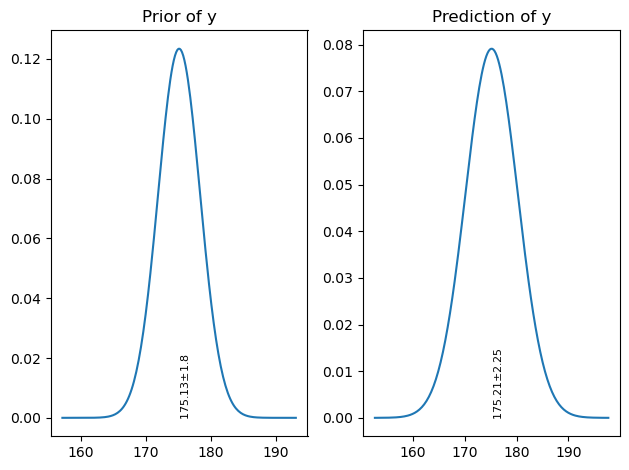

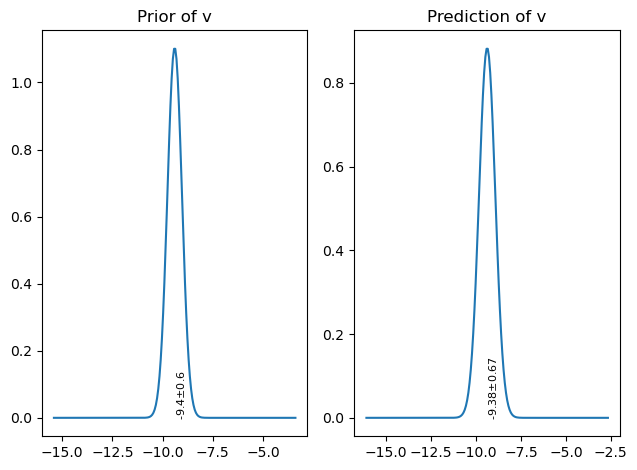

In [13]:
# ---------------------- #
# Prediction of longitudinal (y) component
yy = y_tPlus1_t[0]
Pyy = P_tPlus1_t[0,0]

plt.figure()
plt.subplot(1,2,1)
# Prior
plot_gmm(np.array([filt.mu_y[0]]), np.array([filt.P_y[0,0]]), np.array(filt.wy))
plt.title('Prior of y')

# Prediction
plt.subplot(1,2,2)
plot_gmm(np.array([yy]), np.array([Pyy]), np.array([w_tPlus1_t]))
plt.title('Prediction of y')

plt.tight_layout()

# ---------------------- #
# Prediction of longitudinal velocity (v) component
vy = y_tPlus1_t[1]
Pvy = P_tPlus1_t[1,1]

plt.figure()
plt.subplot(1,2,1)
# Prior
plot_gmm(np.array([filt.mu_y[1]]), np.array([filt.P_y[1,1]]), np.array(filt.wy))
plt.title('Prior of v')

# Prediction
plt.subplot(1,2,2)
plot_gmm(np.array([vy]), np.array([Pvy]), np.array([w_tPlus1_t]))
plt.title('Prediction of v')

plt.tight_layout()

(68.0, 72.0)

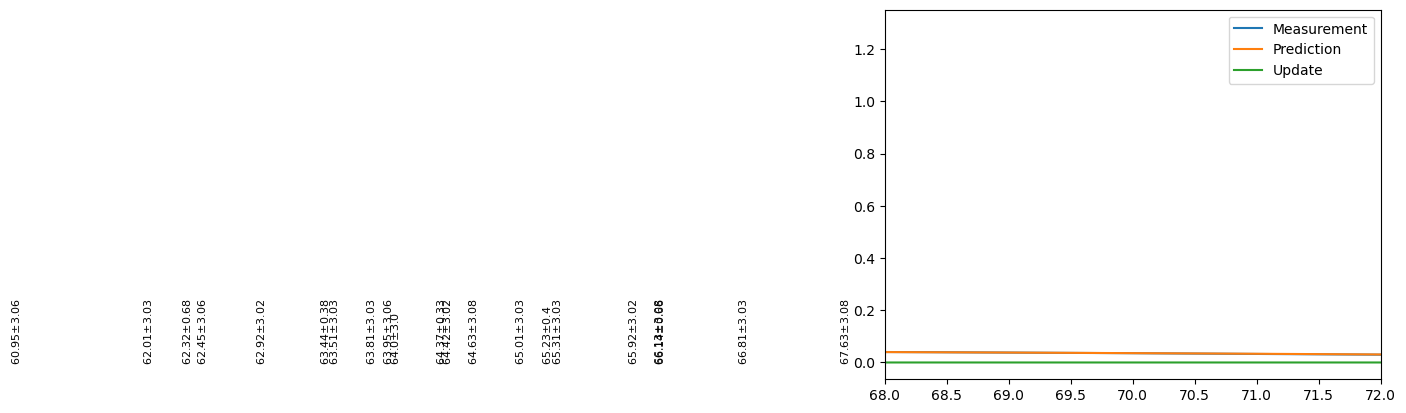

In [14]:
# Update of lateral (x) component
plot_gmm(np.array([x_test[filt.t + 1]]), np.array(filt.P_zx), np.array([1]))
plot_gmm(mu_x_pred, P_x_pred + filt.P_zx, w_x_pred)
plot_gmm(mu_x_tPlus1_tPlus1, P_x_tPlus1_tPlus1, w_x_tPlus1_tPlus1)
plt.legend(['Measurement', 'Prediction', 'Update'])
plt.xlim((68,72))

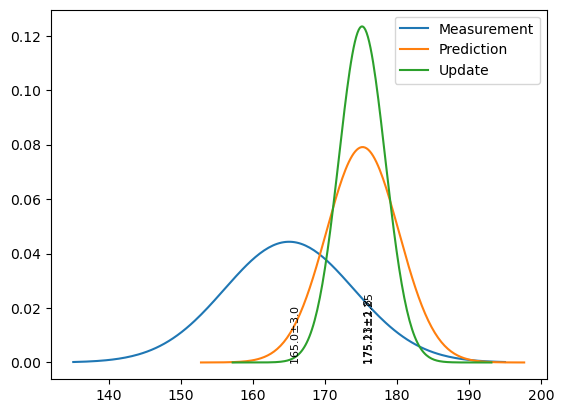

In [15]:
# Update of longitudinal (y) component
plot_gmm(np.array([y_test[filt.t + 1]]), np.array(filt.P_zy), np.array([1])) # measurement
plot_gmm(np.array([yy]), np.array([Pyy]), np.array([w_tPlus1_t])) # prediction 
plot_gmm(np.array([mu_y_tPlus1_tPlus1[0]]), np.array([P_y_tPlus1_tPlus1[0,0]]), np.array([w_y_tPlus1_tPlus1])) # update
plt.legend(['Measurement', 'Prediction', 'Update'])

In [16]:
# Posterior estimate:
print('Posterior of x: ', mu_x_tPlus1_tPlus1, P_x_tPlus1_tPlus1, w_x_tPlus1_tPlus1)
print('Posterior of y: ', mu_y_tPlus1_tPlus1, P_y_tPlus1_tPlus1, w_y_tPlus1_tPlus1)

Posterior of x:  [65.22726049 62.32277986 64.37362043 63.4398991  66.14011104] [0.16275036 0.45678439 0.10573678 0.1472355  0.42996589] [0.19864448 0.10476764 0.34306231 0.279969   0.07355657]
Posterior of y:  [175.1347213   -9.39936776] [[3.23210485 0.64464949]
 [0.80526018 0.36123659]] [1]


In [17]:
# check for the positive definiteness of P_y_tPlus1_tPlus1
Pyt_post_eigs = np.linalg.eigvals(P_y_tPlus1_tPlus1)
if Pyt_post_eigs[Pyt_post_eigs < 0].any():
    print('WARNING: P_y_tPlus1_tPlus1 is NOT positive definite')
else:
    print('P_y_tPlus1_tPlus1 is positive definite')

P_y_tPlus1_tPlus1 is positive definite


In [18]:
filt.state_write(updaton=updaton) # write the update to the state
print('State update. The next iteration corresponds to t = {}'.format(filt.t))

State update. The next iteration corresponds to t = 49


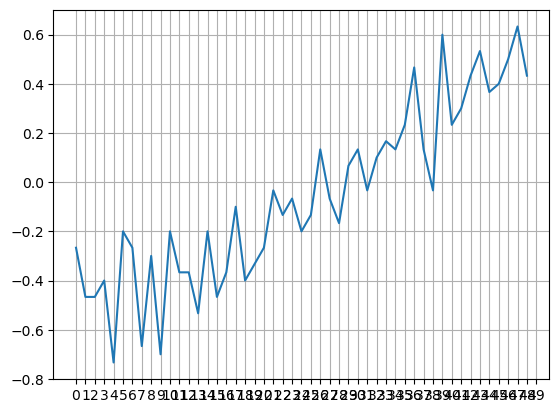

In [19]:
plt.plot(v_mean)
plt.grid()
plt.xticks(np.arange(50))
plt.show()